In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\frase\AppData\Local\Temp\ipykernel_26272\486377480.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def make_design(x,poly_order):
    #first we make the sin term:
    X = np.sin(2*np.pi/0.3 * x)

    #now add polynomial terms
    for p in range(1, poly_order + 1):
        X = np.concatenate([X, x ** p], axis=1)
    return X

(200, 1)


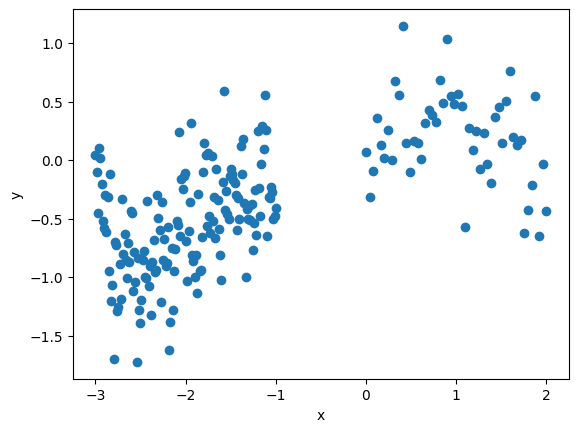

In [16]:
### 1) ###
q1_data = pd.read_csv("/University-local\/Imperial/Term 2/Machine Learning/ML/CW_1/data_2476922.csv")


x = q1_data["x"].to_numpy()[:,None]
y = q1_data[" y"].to_numpy()[:,None]


#do train split so we can show overfitting and underfitting


plt.plot(x,y,"o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

def get_mse(x, y, poly_order) -> float:
    
    X = make_design(x,poly_order=poly_order)

    #now split the same each time
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=8)

    # solve for coefs such that X^T @ X @ coefs = X.T @ y
    coefs = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
    pred_y = X_train @ coefs
    mse = np.mean((pred_y - y_train) ** 2)
    #test
    pred_y_test = X_test @ coefs
    mse_test = np.mean((pred_y_test - y_test) ** 2)

    return (mse,mse_test,coefs)


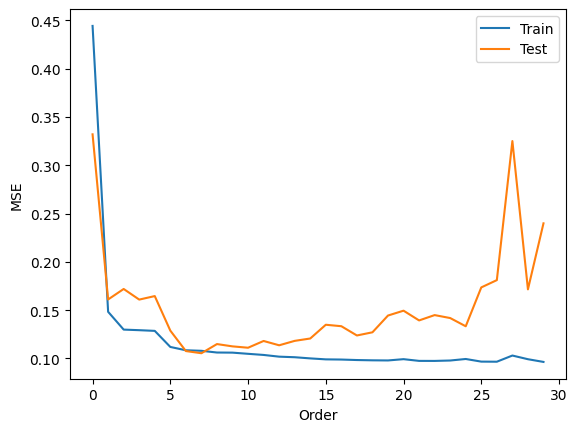

0.4442541021957682


In [4]:
#we now do plots 

orders = [i for i in range(0, 30)]
MSE = [get_mse(x, y, p) for p in orders]
coefs = [sublist[2] for sublist in MSE]

plt.plot(
    orders,
    [sublist[0] for sublist in MSE],
    label="Train",
)
plt.plot(
    orders,
    [sublist[1] for sublist in MSE],
    label="Test",
)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Order")
plt.show()
print(MSE[0][0])

(100, 1)


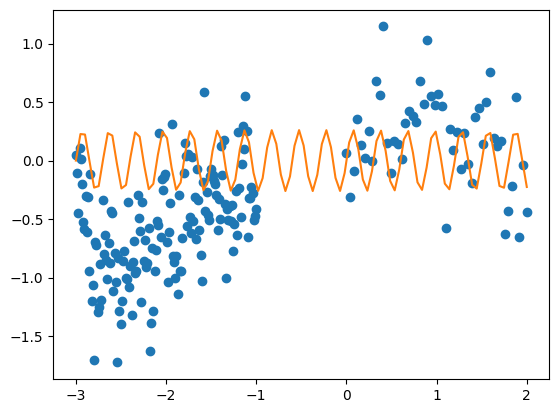

In [5]:
x_range = np.linspace(-3,2,100)[:,None]
polyorder = 0
X_range = make_design(x_range,polyorder )
print(X_range.shape)

y_range = X_range @ coefs[polyorder]

plt.plot(x,y,"o")
plt.plot(x_range,y_range)
    

In [6]:
### 1) 2 ###

polyorder = 10



#we split the data before putting into matrix form purely so we can plot it easier later

#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0,random_state=5)


#Now, since we have fixed polyorder, lets create the design matrix:

#we find lambda on the whole dataset
X = make_design(x,polyorder)


def LOOCV_lambda(X, y, lambda_):
    # X is the matrix of features (including polynomials)
    # y is a vector containing the targets
    # lambda_ is the parameter for ridge regression

    NumOfDataPairs = len(y)

    # Initialize CV variable for storing results
    CV = np.zeros(NumOfDataPairs)

    for n in range(NumOfDataPairs):

        # Create training design matrix and target data, leaving one out each time
        Train_X = np.delete(X, n, axis=0)
        Train_y = np.delete(y, n)

        # Create testing design matrix and target data
        Test_X = X[n, :]
        Test_y = y[n]

        # Learn the optimal parameters using MSE loss
        Paras_hat = np.linalg.solve(Train_X.T @ Train_X + lambda_ * np.eye(X.shape[1]), Train_X.T @ Train_y)
        Pred_y = Test_X @ Paras_hat

        # Calculate the MSE of prediction using training data
        CV[n] = (Pred_y - Test_y) ** 2

    return np.mean(CV)




C:\Users\frase\AppData\Local\Temp\ipykernel_26272\3059834414.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CV[n] = (Pred_y - Test_y) ** 2


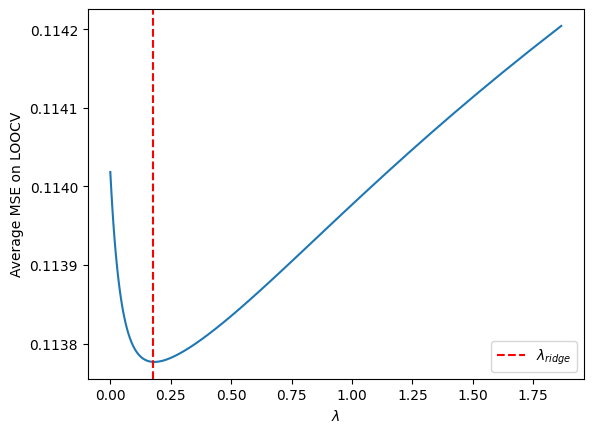

Average MSE on LOOCV minimized for lambda_hat = 0.1768


In [7]:
lmbdas = np.concatenate(([0], 2 ** np.arange(-10, 1, 0.1)))
CVlambda = np.array([LOOCV_lambda(X, y, lambda_) for lambda_ in lmbdas])
plt.plot(lmbdas, CVlambda)
plt.ylabel("Average MSE on LOOCV")
plt.xlabel("$\lambda$")

# Find the lambda value that minimizes the average MSE
lambda_l = lmbdas[np.argmin(CVlambda)]

plt.axvline(x = lambda_l, color = "r", linestyle = "--", label = "$\lambda_{ridge}$")
plt.legend()
plt.show()



print(f"Average MSE on LOOCV minimized for lambda_hat = {lambda_l:.4f}")
#We obtain the following values:

In [8]:
#we now have our best lambda, so we fit both OLS and ridge on training set, and test it on a test set

#810
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=50)

#design matrices
X_train= make_design(x_train,polyorder)
X_test= make_design(x_test,polyorder)

In [251]:



OLS_coefs = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
#OLS_coefs = np.linalg.solve(X.T @ X, X.T @ y)
Ridge_coefs = np.linalg.solve(X_train.T @ X_train + lambda_l * np.eye(X_train.shape[1]), X_train.T @ y_train)
#Ridge_coefs =np.linalg.solve(X.T @ X + lambda_l * np.eye(X.shape[1]), X.T @ y)
print(OLS_coefs)
print(Ridge_coefs)

y_test_pred_OLS = X_test @ OLS_coefs
OLS_mse_test = np.mean((y_test_pred_OLS - y_test)**2)
y_test_pred_Ridge = X_test @ Ridge_coefs
Ridge_mse_test = np.mean((y_test_pred_Ridge - y_test)**2)

y_train_pred_OLS = X_train @ OLS_coefs
OLS_mse_train = np.mean((y_train_pred_OLS - y_train)**2)
y_train_pred_ridge = X_train @ Ridge_coefs
Ridge_mse_train = np.mean((y_train_pred_ridge - y_train)**2)


[[ 0.21929367]
 [ 1.04387307]
 [ 0.04182324]
 [-1.13823919]
 [-0.02176447]
 [ 0.5928021 ]
 [ 0.0256779 ]
 [-0.14808561]
 [-0.01911057]
 [ 0.01426569]
 [ 0.00307216]]
[[ 0.21265045]
 [ 0.66580177]
 [ 0.1839269 ]
 [-0.44672308]
 [-0.13619083]
 [ 0.16039533]
 [ 0.02875529]
 [-0.03477865]
 [-0.00623618]
 [ 0.00358342]
 [ 0.00089136]]


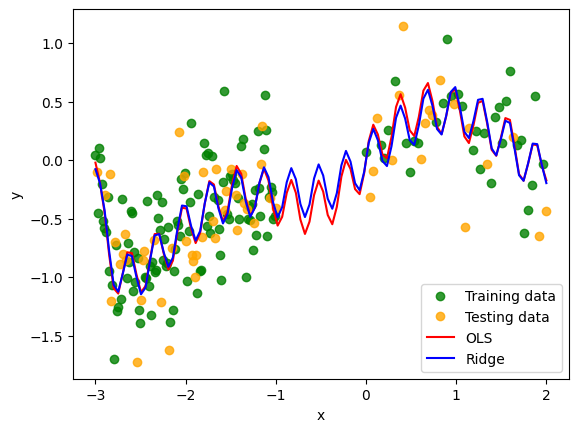

In [10]:
#plot them

plt.plot(x_train,y_train,"o", color = "g", label = "Training data", alpha = 0.8)
plt.plot(x_test,y_test, "o", color = "orange",label = "Testing data", alpha = 0.8)


x_range = np.linspace(-3,2,100)[:,None]
X_range = np.sin(2*np.pi/0.3 * x_range)
polyorder = 10
X_range = make_design(x_range, polyorder)
#OLS
y_range_OLS = X_range @ OLS_coefs
# Ridge
y_range_Ridge = X_range @ Ridge_coefs

plt.plot(x_range, y_range_OLS, color = "r" ,label = "OLS")
plt.plot(x_range, y_range_Ridge, color = "b", label = "Ridge")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

0.5091168824543236
(100000, 11, 1)


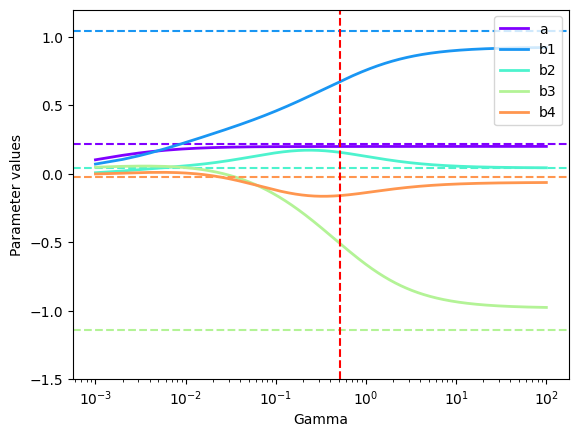

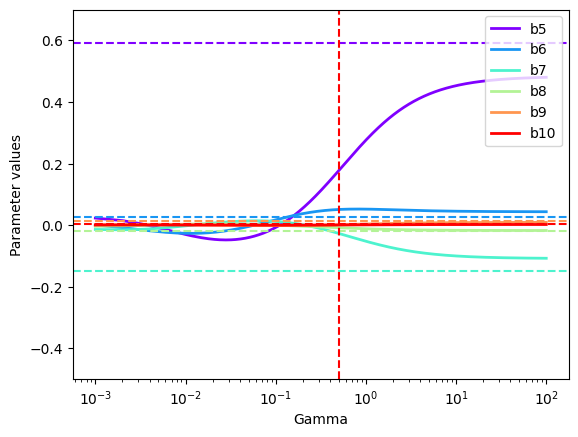

0.2192936658318055


In [26]:
### 1) 2c ###

sigma = 0.3

gammalist = np.arange(0.001, 100.001, 0.001)
#find value of gamma that gives the ridge value:
gamma_ridge = sigma**2 / lambda_l
print(gamma_ridge)
# Calculate mu for each alpha
mu = np.array([np.linalg.solve(X.T @ X + np.diag(np.repeat(sigma**2/gamma, X.shape[1])), X.T @ y) for gamma in gammalist])
print(mu.shape)
# Define color palette
color_palette = plt.cm.rainbow(np.linspace(0, 1, 6))


# Plot the first 5 rows of mu against gamma
param_names = ["a", "b1", "b2", "b3", "b4","b5", "b6", "b7", "b8","b9","b10"]
plt.figure()
for i in range(5):
    plt.plot(gammalist, mu[:, i], color=color_palette[i], linewidth=2,label = param_names[i])
    plt.axhline(y = OLS_coefs[i][0], color=color_palette[i], linestyle = "--")
plt.axvline(x = gamma_ridge,linestyle = "--",color = "r")
plt.ylim((-1.5,1.2))
plt.xlabel("Gamma")
plt.ylabel("Parameter values")
plt.xscale("log")
plt.legend(loc="upper right")

# Plot the last 5 rows of mu against gamma
plt.figure()
for i in range(5, 11):
    plt.plot(gammalist, mu[:, i], color=color_palette[i-5], linewidth=2,label = param_names[i])
    plt.axhline(y = OLS_coefs[i][0], color=color_palette[i-5], linestyle = "--")
plt.axvline(x = gamma_ridge,linestyle = "--",color = "r")
plt.ylim((-0.5,0.7))
plt.xlabel("Gamma")
plt.ylabel("Parameter values")
plt.xscale("log")
plt.legend(loc="upper right")

plt.show()
print(OLS_coefs[0][0])

In [175]:
X = make_design(x,polyorder)
def posterior_predictive(x_point,gamma):
    mu = np.linalg.solve(X.T @ X + np.diag(np.repeat(sigma**2/gamma, X.shape[1])), X.T @ y)
    Sigma = np.linalg.inv(X.T @ X + np.diag(np.repeat(sigma**2/gamma, X.shape[1]))) * sigma**2
    #change x to be of desired form
    x_point = np.array([x_point])[:,None]
    x_point = make_design(x_point,polyorder)[0][:,None]
    mu_new = x_point.T @ mu
    Sigma_new = x_point.T@ Sigma @ x_point + sigma**2
    return (mu_new,Sigma_new)



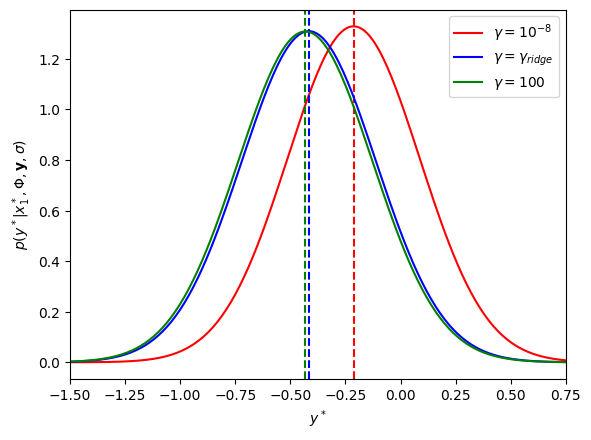

In [176]:
from scipy.stats import norm

xlist = [-2,-0.5,1]
gamma_range = [0.00000001,gamma_ridge,100]
x_axis = np.arange(-2,1,0.01)
#color
color_palette = ["red","blue","green"]
labels = ["$\gamma = 10^{-8}$", "$\gamma = \gamma_{ridge}$", "$\gamma = 100$"] 
for i in range(3):
    gamma = gamma_range[i]
    plt.plot(x_axis,norm.pdf(x_axis,
                             posterior_predictive(xlist[0],gamma)[0][0][0],
                             np.sqrt(posterior_predictive(xlist[0],gamma)[1][0][0])),color = color_palette[i], label = labels[i])
    plt.axvline(x =posterior_predictive(xlist[0],gamma)[0][0][0], color = color_palette[i] ,linestyle = "--")
plt.xlim((-1.5,0.75))
plt.xlabel("$y^*$")
plt.ylabel("$p(y^*|x_1^*,\Phi,\mathbf{y},\sigma)$")
plt.legend()
plt.show()


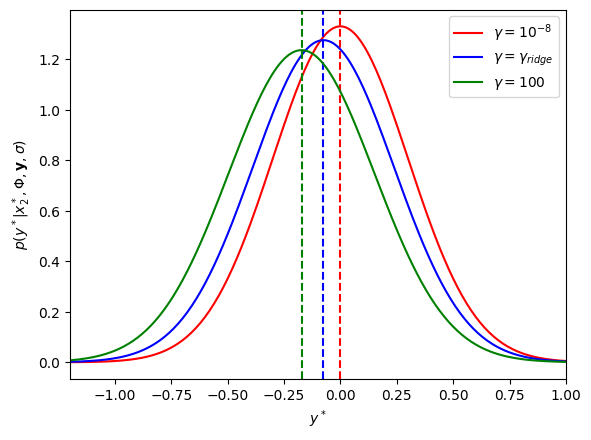

In [177]:
from scipy.stats import norm

xlist = [-2,-0.5,1]
gamma_range = [0.00000001,gamma_ridge,100]
x_axis = np.arange(-1.5,1.5,0.01)
#color
color_palette = ["red","blue","green"]
labels = ["$\gamma = 10^{-8}$", "$\gamma = \gamma_{ridge}$", "$\gamma = 100$"] 
for i in range(3):
    gamma = gamma_range[i]
    plt.plot(x_axis,norm.pdf(x_axis,posterior_predictive(xlist[1],gamma)[0][0][0],np.sqrt(posterior_predictive(xlist[1],gamma)[1][0][0])),color = color_palette[i], label = labels[i])
    plt.axvline(x =posterior_predictive(xlist[1],gamma)[0][0][0], color = color_palette[i] ,linestyle = "--")
plt.xlim((-1.2,1))
plt.xlabel("$y^*$")
plt.ylabel("$p(y^*|x_2^*,\Phi,\mathbf{y},\sigma)$")
plt.legend()
plt.show()

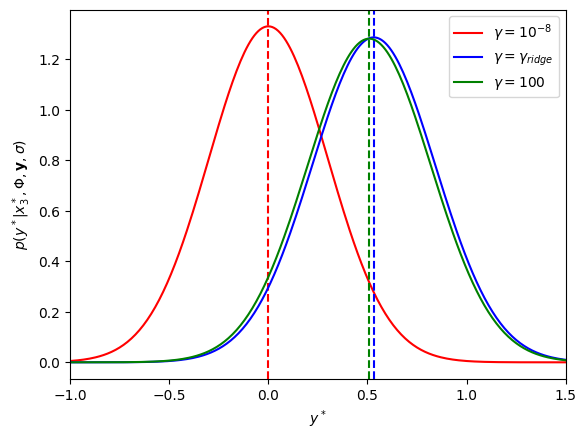

In [178]:
from scipy.stats import norm

xlist = [-2,-0.5,1]
gamma_range = [0.00000001,gamma_ridge,100]
x_axis = np.arange(-1,2,0.01)
#color
color_palette = ["red","blue","green"]
labels = ["$\gamma = 10^{-8}$", "$\gamma = \gamma_{ridge}$", "$\gamma = 100$"] 
for i in range(3):
    gamma = gamma_range[i]
    plt.plot(x_axis,norm.pdf(x_axis,posterior_predictive(xlist[2],gamma)[0][0][0],np.sqrt(posterior_predictive(xlist[2],gamma)[1][0][0])),color = color_palette[i], label = labels[i])
    plt.axvline(x =posterior_predictive(xlist[2],gamma)[0][0][0], color = color_palette[i] ,linestyle = "--")
plt.xlim((-1,1.5))
plt.xlabel("$y^*$")
plt.ylabel("$p(y^*|x_3^*,\Phi,\mathbf{y},\sigma)$")
plt.legend()
plt.show()

In [253]:
xlist = [-2,-0.5,1]

#calc ridge prediction for each:
x_design_list = [np.array([i])[:,None] for i in xlist]
x_design_list = [make_design(i,polyorder)[0][:,None] for i in x_design_list]
ridge_predict = [X_new.T @ Ridge_coefs for X_new in x_design_list]
ridge_predict = [i[0][0] for i in ridge_predict]
print(ridge_predict)


[-0.3760645121596572, -0.05975184320683698, 0.6035860283269343]


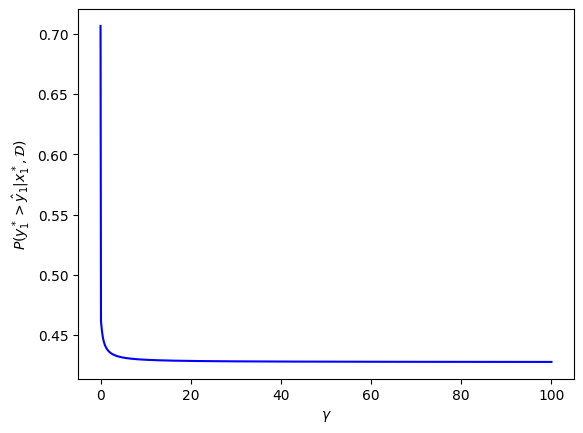

[0.5789066213859615, 0.5686610460231185, 0.5352922698431954, 0.5122346591807039, 0.49478954544774134, 0.48102722008948684, 0.46986599252128625, 0.4606237916430952, 0.452842077305756, 0.4461990812372483, 0.4404616344220693, 0.43545637030050877, 0.43105160247682905, 0.4271454654202409, 0.4236579072685869, 0.42052513975067485, 0.41769570443318826, 0.41512763048762225, 0.41278634359498134, 0.4106431062149336, 0.40867383580705596, 0.40685819897376774, 0.4051789104489434, 0.40362118172311345, 0.40217228727796084, 0.4008212162951482, 0.3995583939140772, 0.3983754543318456, 0.3972650561688722, 0.39622073021558457, 0.39523675378314993, 0.39430804681456166, 0.39343008199832397, 0.3925988147253725, 0.39181061745207413, 0.3910622297100723, 0.3903507118490903, 0.3896734056700859, 0.3890279031125917, 0.3884120166999181, 0.38782375453895557, 0.38726130018402893, 0.38672299239310104, 0.3862073096610025, 0.38571285524681764, 0.3852383455387862, 0.38478259833018735, 0.38434452201019564, 0.38392310950754

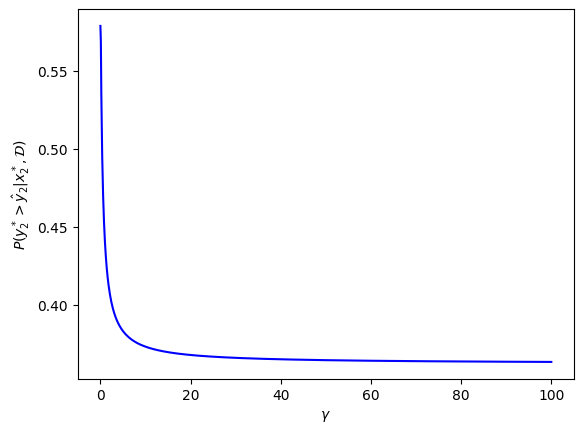

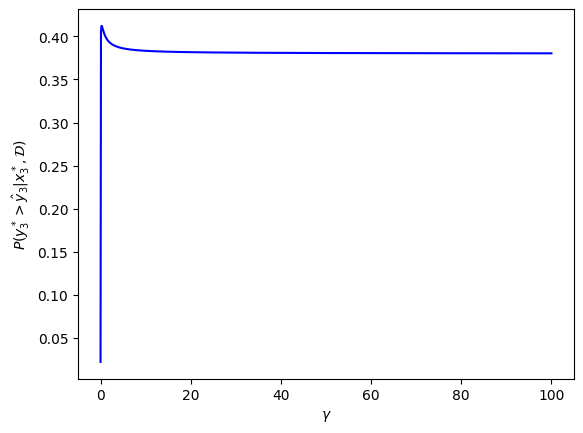

In [255]:
from scipy.stats import norm
gammalist = np.arange(0.00000001, 100.1, 0.1)
#now find the probability
def find_prob(mu,var,ridge_val):
    return 1 - norm.cdf(ridge_val,loc = mu, scale = np.sqrt(var))

#take first x case
xpar = xlist[0]
p = [find_prob(posterior_predictive(xpar,g)[0][0][0],posterior_predictive(xpar,g)[1][0][0],ridge_predict[0]) for g in gammalist]
plt.plot(gammalist,p, label = "$$", color = "b")
plt.xlabel("$\gamma$")
plt.ylabel("$P(y_1^* > \hat{y}_{1} | x_1^*, \mathcal{D})$")
plt.show()
#take second x case
xpar = xlist[1]
p = [find_prob(posterior_predictive(xpar,g)[0][0][0],posterior_predictive(xpar,g)[1][0][0],ridge_predict[1]) for g in gammalist]
print(p)
plt.plot(gammalist,p, color = "b")
plt.xlabel("$\gamma$")
plt.ylabel("$P(y_2^* > \hat{y}_{2} | x_2^*, \mathcal{D})$")
plt.show()
#take third x case
xpar = xlist[2]
p = [find_prob(posterior_predictive(xpar,g)[0][0][0],posterior_predictive(xpar,g)[1][0][0],ridge_predict[2]) for g in gammalist]
plt.plot(gammalist,p, color = "b")
plt.xlabel("$\gamma$")
plt.ylabel("$P(y_3^* > \hat{y}_{3} | x_3^*, \mathcal{D})$")
plt.show()